In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from menelaus.datasets import fetch_rainfall_data
import pandas as pd
import numpy as np
# read in data
df = fetch_rainfall_data()
# train test split
X_train, X_test, y_train, y_test = train_test_split(
     df.iloc[:,:-1], df.iloc[:,-1], test_size=0.5, 
     random_state=42,     shuffle = False
)
# apply classifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
# get running accuracy from classifier to compare performance
acc_orig = np.cumsum(knn.predict(X_test) == y_test)
acc_orig = acc_orig / np.arange(1, 1 + len(acc_orig))









9079
18159
9079


In [15]:
from menelaus.concept_drift import ADWINAccuracy
adwin = ADWINAccuracy()
# Set up DF to record results.
status = pd.DataFrame(columns=["index", "y_true", "y_pred", "drift_detected"])
print(status)
rec_list = []



Empty DataFrame
Columns: [index, y_true, y_pred, drift_detected]
Index: []


In [16]:
# run ADWIN
for i in range(len(X_train), len(df)):
     x = X_test.loc[[i]]
     y_pred = int(knn.predict(x))
     y_true = int(y_test.loc[[i]])
     adwin.update(y_true, y_pred)
     status.loc[i] = [i, y_true, y_pred, adwin.drift_state]
# If drift is detected, examine the window and retrain.
     if adwin.drift_state == "drift":
          retrain_start = adwin.retraining_recs[0] + len(X_train)
          retrain_end = adwin.retraining_recs[1] + len(X_train)
          rec_list.append([retrain_start, retrain_end])
          # The retraining recommendations produced here 
          # correspond to the samples which belong to ADWIN's 
          # new, smaller window, after drift is detected.
          # If retraining is not desired, omit the next four lines.
          X_train_new = X_test.loc[retrain_start:retrain_end,]
          y_train_new = y_test.loc[retrain_start:retrain_end,]
          knn = KNeighborsClassifier(n_neighbors=10)
          knn.fit(X_train_new, y_train_new)
status['original_accuracy'] = acc_orig
status['accuracy'] = np.cumsum(status.y_true == status.y_pred)
status['accuracy'] = status['accuracy'] / np.cumsum(np.repeat(1,    
     status.shape[0]))

/var/folders/l0/091nq6390xb96z8313zhyp4m0000gp/T/ipykernel_38157/4202429599.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = int(knn.predict(x))
/var/folders/l0/091nq6390xb96z8313zhyp4m0000gp/T/ipykernel_38157/4202429599.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  y_true = int(y_test.loc[[i]])
/var/folders/l0/091nq6390xb96z8313zhyp4m0000gp/T/ipykernel_38157/4202429599.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = int(knn.predict(x))
/var/folders/l0/091nq6390xb96z8313zhyp4m0000gp/T/ipykernel_38157/4202429599.py:

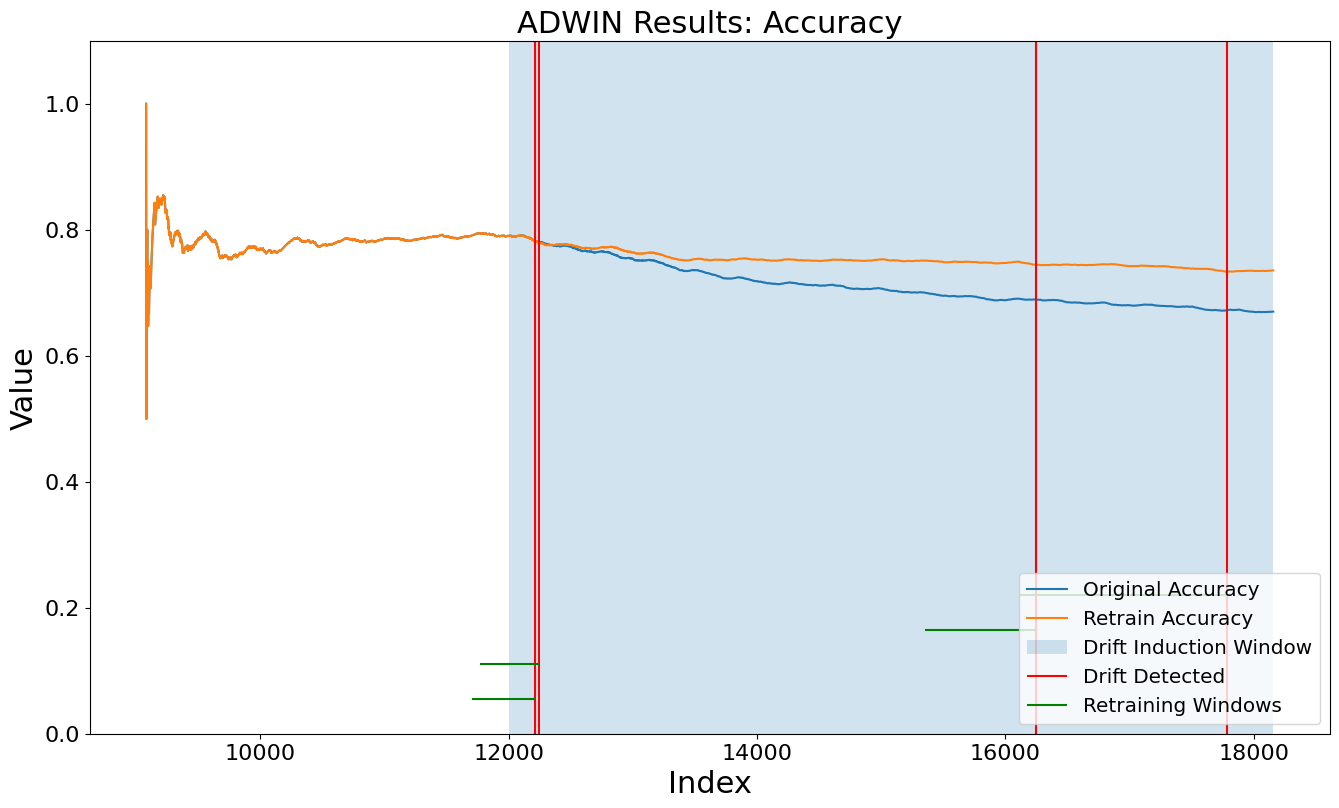

In [17]:
import matplotlib.pyplot as plt
## Plotting ##
plt.figure(figsize=(16, 9))
plt.plot("index", "original_accuracy", data=status, 
     label="Original Accuracy")
plt.plot("index", "accuracy", data=status, 
     label="Retrain Accuracy")
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("ADWIN Results: Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=22)
plt.xlabel("Index", fontsize=22)
ylims = [0, 1.1]
plt.ylim(ylims)
plt.axvspan(12000, len(df), alpha=0.2, label="Drift Induction Window")
# Draw red lines that indicate where drift was detected
plt.vlines(
     x=status.loc[status["drift_detected"] == "drift"]["index"],
     ymin=ylims[0],
     ymax=ylims[1],
     label="Drift Detected",
     color="red",
)
# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
     start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
     stop=0.2 * ylims[1],
     num=len(rec_list),
)
# Draw green lines that indicate where retraining occurred
plt.hlines(
     y=rec_list["y_val"],
     xmin=rec_list[0],
     xmax=rec_list[1],
     color="green",
     label="Retraining Windows",
)
plt.legend(loc='lower right', fontsize='x-large')
plt.show()